# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
import torch
import os

import sys
from pathlib import Path
module_path = Path.cwd().parent / 'utils'
sys.path.append(str(module_path))
import data_processing, visualization
from simulations import *
module_path = Path.cwd().parent / 'execute'
sys.path.append(str(module_path))

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
n_samples = 600
n_features_bytype = 6
n_active_features = 3 
treatment_effect = 0.0
p_treated = 0.5
shape_T = 2.
shape_C = 2.
scale_C = 2.5
scale_C_indep = 3.9
feature_types_list = ["real", "cat"]
independent = True
data_types_create = True

In [3]:
seed = 100
dataset_name = "Simulations"
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
data_file_control= parent_path + "/dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = parent_path + "/dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= parent_path + "/dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= parent_path + "/dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = parent_path + "/dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None
control, treated, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                        n_features_bytype, n_active_features, p_treated, shape_T, shape_C,
                                        scale_C, scale_C_indep, data_types_create, seed=seed)
print("Censoring level of control ", control.censor.sum() / control.censor.shape[0])
print("Censoring level of treated ", treated.censor.sum() / treated.censor.shape[0])


control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

data_file_control = parent_path + "/dataset/" + dataset_name + "/data_control.csv"
data_file_treated = parent_path + "/dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_control = parent_path + "/dataset/" + dataset_name + "/data_types_control.csv"
feat_types_file_treated= parent_path + "/dataset/" + dataset_name + "/data_types_treated.csv"

control.to_csv(data_file_control, index=False , header=False)
treated.to_csv(data_file_treated, index=False , header=False)
types.to_csv(feat_types_file_control)
types.to_csv(feat_types_file_treated)


# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control,
                                                                                                                    feat_types_file_control, 
                                                                                                                    miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

# Format data in dataframe
control_fnames = types['name'][:-1].tolist()
control_fnames.append("time")#.append("censor")
control_fnames.append("censor")

Censoring level of control  0.8618421052631579
Censoring level of treated  0.902027027027027


### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [4]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

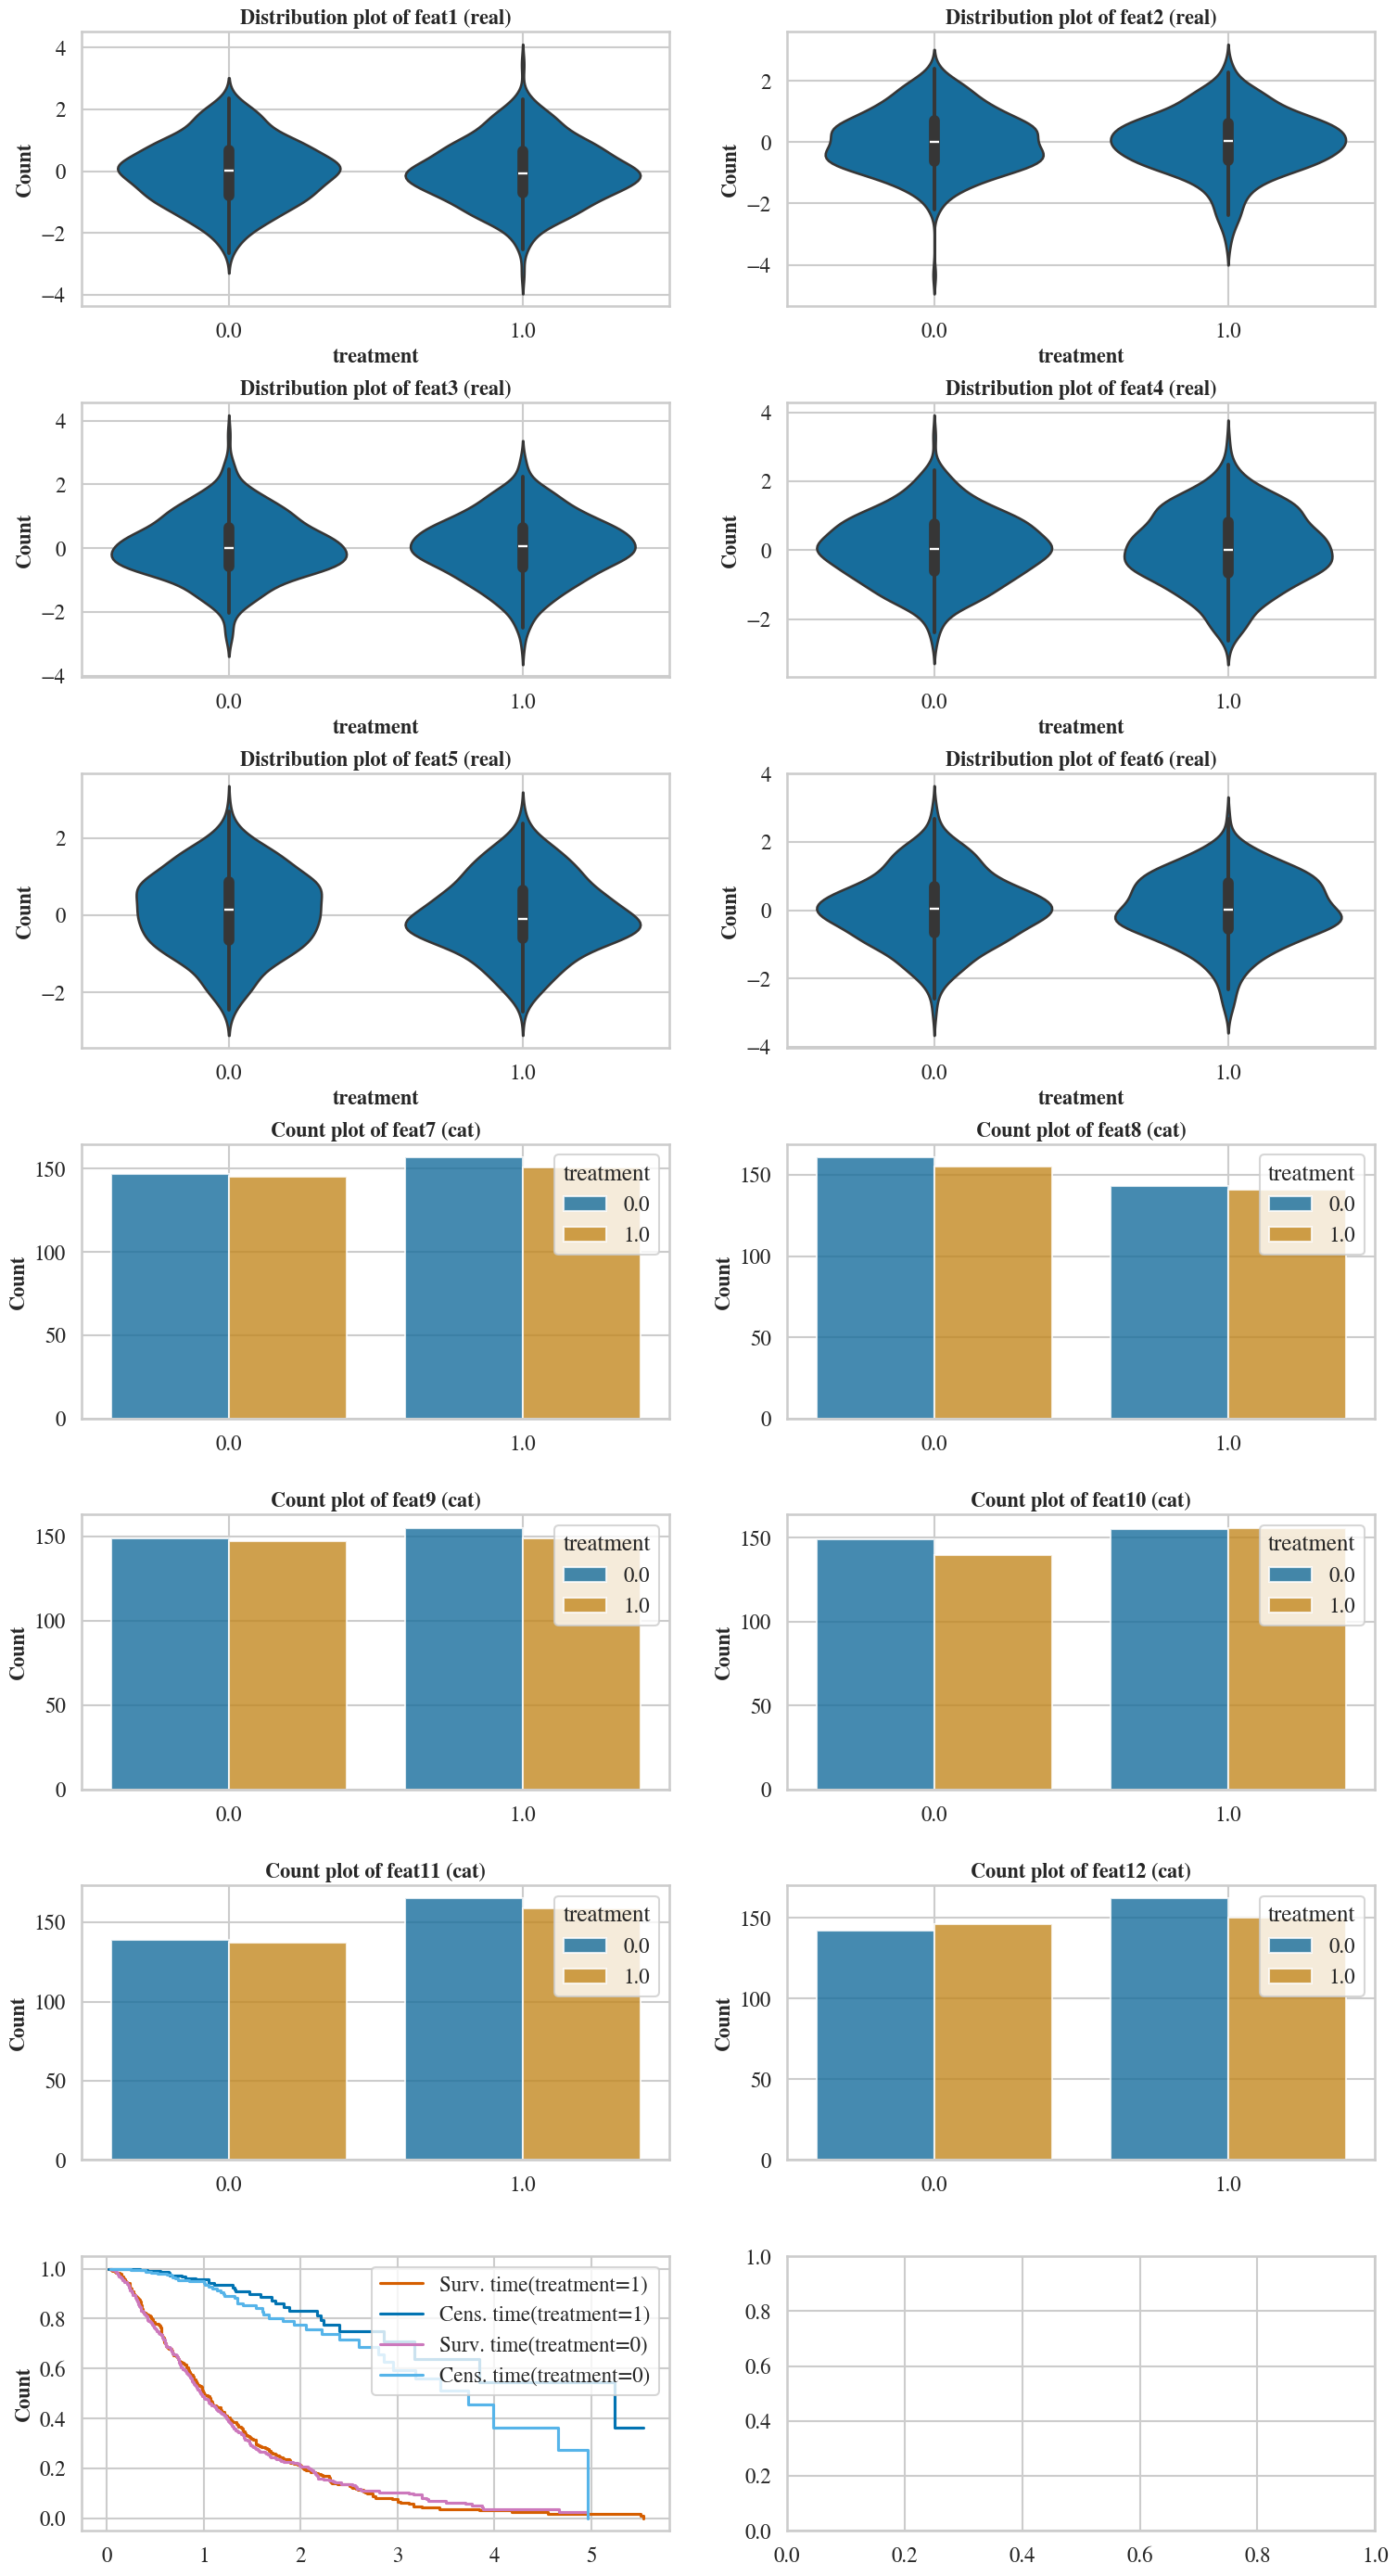

In [5]:
# TODO: Refactor
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [6]:
continuous = ['time', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6']
categorical = ['censor', 'feat7', 'feat8', 'feat9', 'feat10', 'feat11', 'feat12', 'treatment']
nonnormal = ['time']

table1 = TableOne(df_init, categorical=categorical, continuous=continuous, 
                  groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                     
                                      Missing        Overall              0              1 P-Value
n                                                        600            304            296        
feat1, mean (SD)                            0     -0.0 (1.0)     -0.0 (1.0)     -0.0 (1.0)   0.990
feat2, mean (SD)                            0      0.0 (1.0)      0.1 (1.0)     -0.0 (1.0)   0.431
feat3, mean (SD)                            0      0.0 (1.0)      0.1 (1.0)      0.0 (1.0)   0.701
feat4, mean (SD)                            0      0.1 (1.0)      0.1 (1.0)      0.0 (1.1)   0.841
feat5, mean (SD)                            0      0.1 (1.0)      0.1 (1.0)      0.0 (1.0)   0.249
feat6, mean (SD)                            0      0.1 (1.0)      0.1 (1.0)      0.1 (1.0)   0.972
feat7, n (%)         0.0                          292 (48.7)     147 (48.4)     145 (49.0)   0.942
          

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [7]:
import surv_hivae, surv_vae, surv_gan
import json
treatment_effect_best_param = 0.
metric_optuna = "survival_km_distance"
# Parameters of the optuna study
multiplier_trial = 10 # multiplier for the number of trials
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 50 # number of generated datasets per fold to compute the metric
name_config = "simu_N{}_nfeat{}_t{}".format(n_samples, n_features_bytype, int(treatment_effect_best_param))

generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                "HI-VAE_piecewise" : surv_hivae}


# BEST PARAMETERS
best_params_dict = {}
for generator_name in generators_sel:
    n_trials = 150
    best_params_file = parent_path + "/dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    with open(best_params_file, "r") as f:
        best_params_dict[generator_name] = json.load(f)

# the datasets used for training is data_init_control
n_generated_dataset = 50

In [8]:
feat_types_dict_ext = feat_types_dict.copy()
for i in range(len(feat_types_dict)):
    if feat_types_dict_ext[i]['name'] == "survcens":
        feat_types_dict_ext[i]["type"] = 'surv_weibull'
data_gen_control = surv_hivae.run(df_init_control_encoded,
                                  miss_mask_control, 
                                  true_miss_mask_control,
                                  feat_types_dict_ext,
                                  n_generated_dataset,
                                  params=best_params_dict["HI-VAE_weibull"],
                                  epochs=10000)

Epoch: [ 0]  time: 0.1381, ELBO_train: -16.24536896, KL_z: 2.45994353, KL_s: 0.10512400, reconstruction loss: -13.68030143
Epoch: [100]  time: 1.0588, ELBO_train: -12.47845078, KL_z: 1.21099544, KL_s: 0.03055525, reconstruction loss: -11.23690009
Epoch: [200]  time: 1.9119, ELBO_train: -12.29681778, KL_z: 1.26139426, KL_s: 0.01740789, reconstruction loss: -11.01801562
Epoch: [300]  time: 2.7782, ELBO_train: -12.24719334, KL_z: 1.31907201, KL_s: 0.01546526, reconstruction loss: -10.91265607
Epoch: [400]  time: 3.6401, ELBO_train: -12.28585911, KL_z: 1.40179014, KL_s: 0.01500130, reconstruction loss: -10.86906767
Epoch: [500]  time: 4.4160, ELBO_train: -11.89694405, KL_z: 1.44064128, KL_s: 0.01504469, reconstruction loss: -10.44125807
Epoch: [600]  time: 5.1829, ELBO_train: -12.07519150, KL_z: 1.54859793, KL_s: 0.01516008, reconstruction loss: -10.51143348
Epoch: [700]  time: 5.9899, ELBO_train: -11.78511810, KL_z: 1.61406457, KL_s: 0.01572847, reconstruction loss: -10.15532506
Epoch: [8

## 3. Analyze the generated data

### 3.1. Statistical analysis: one generated control group vs. initial control data

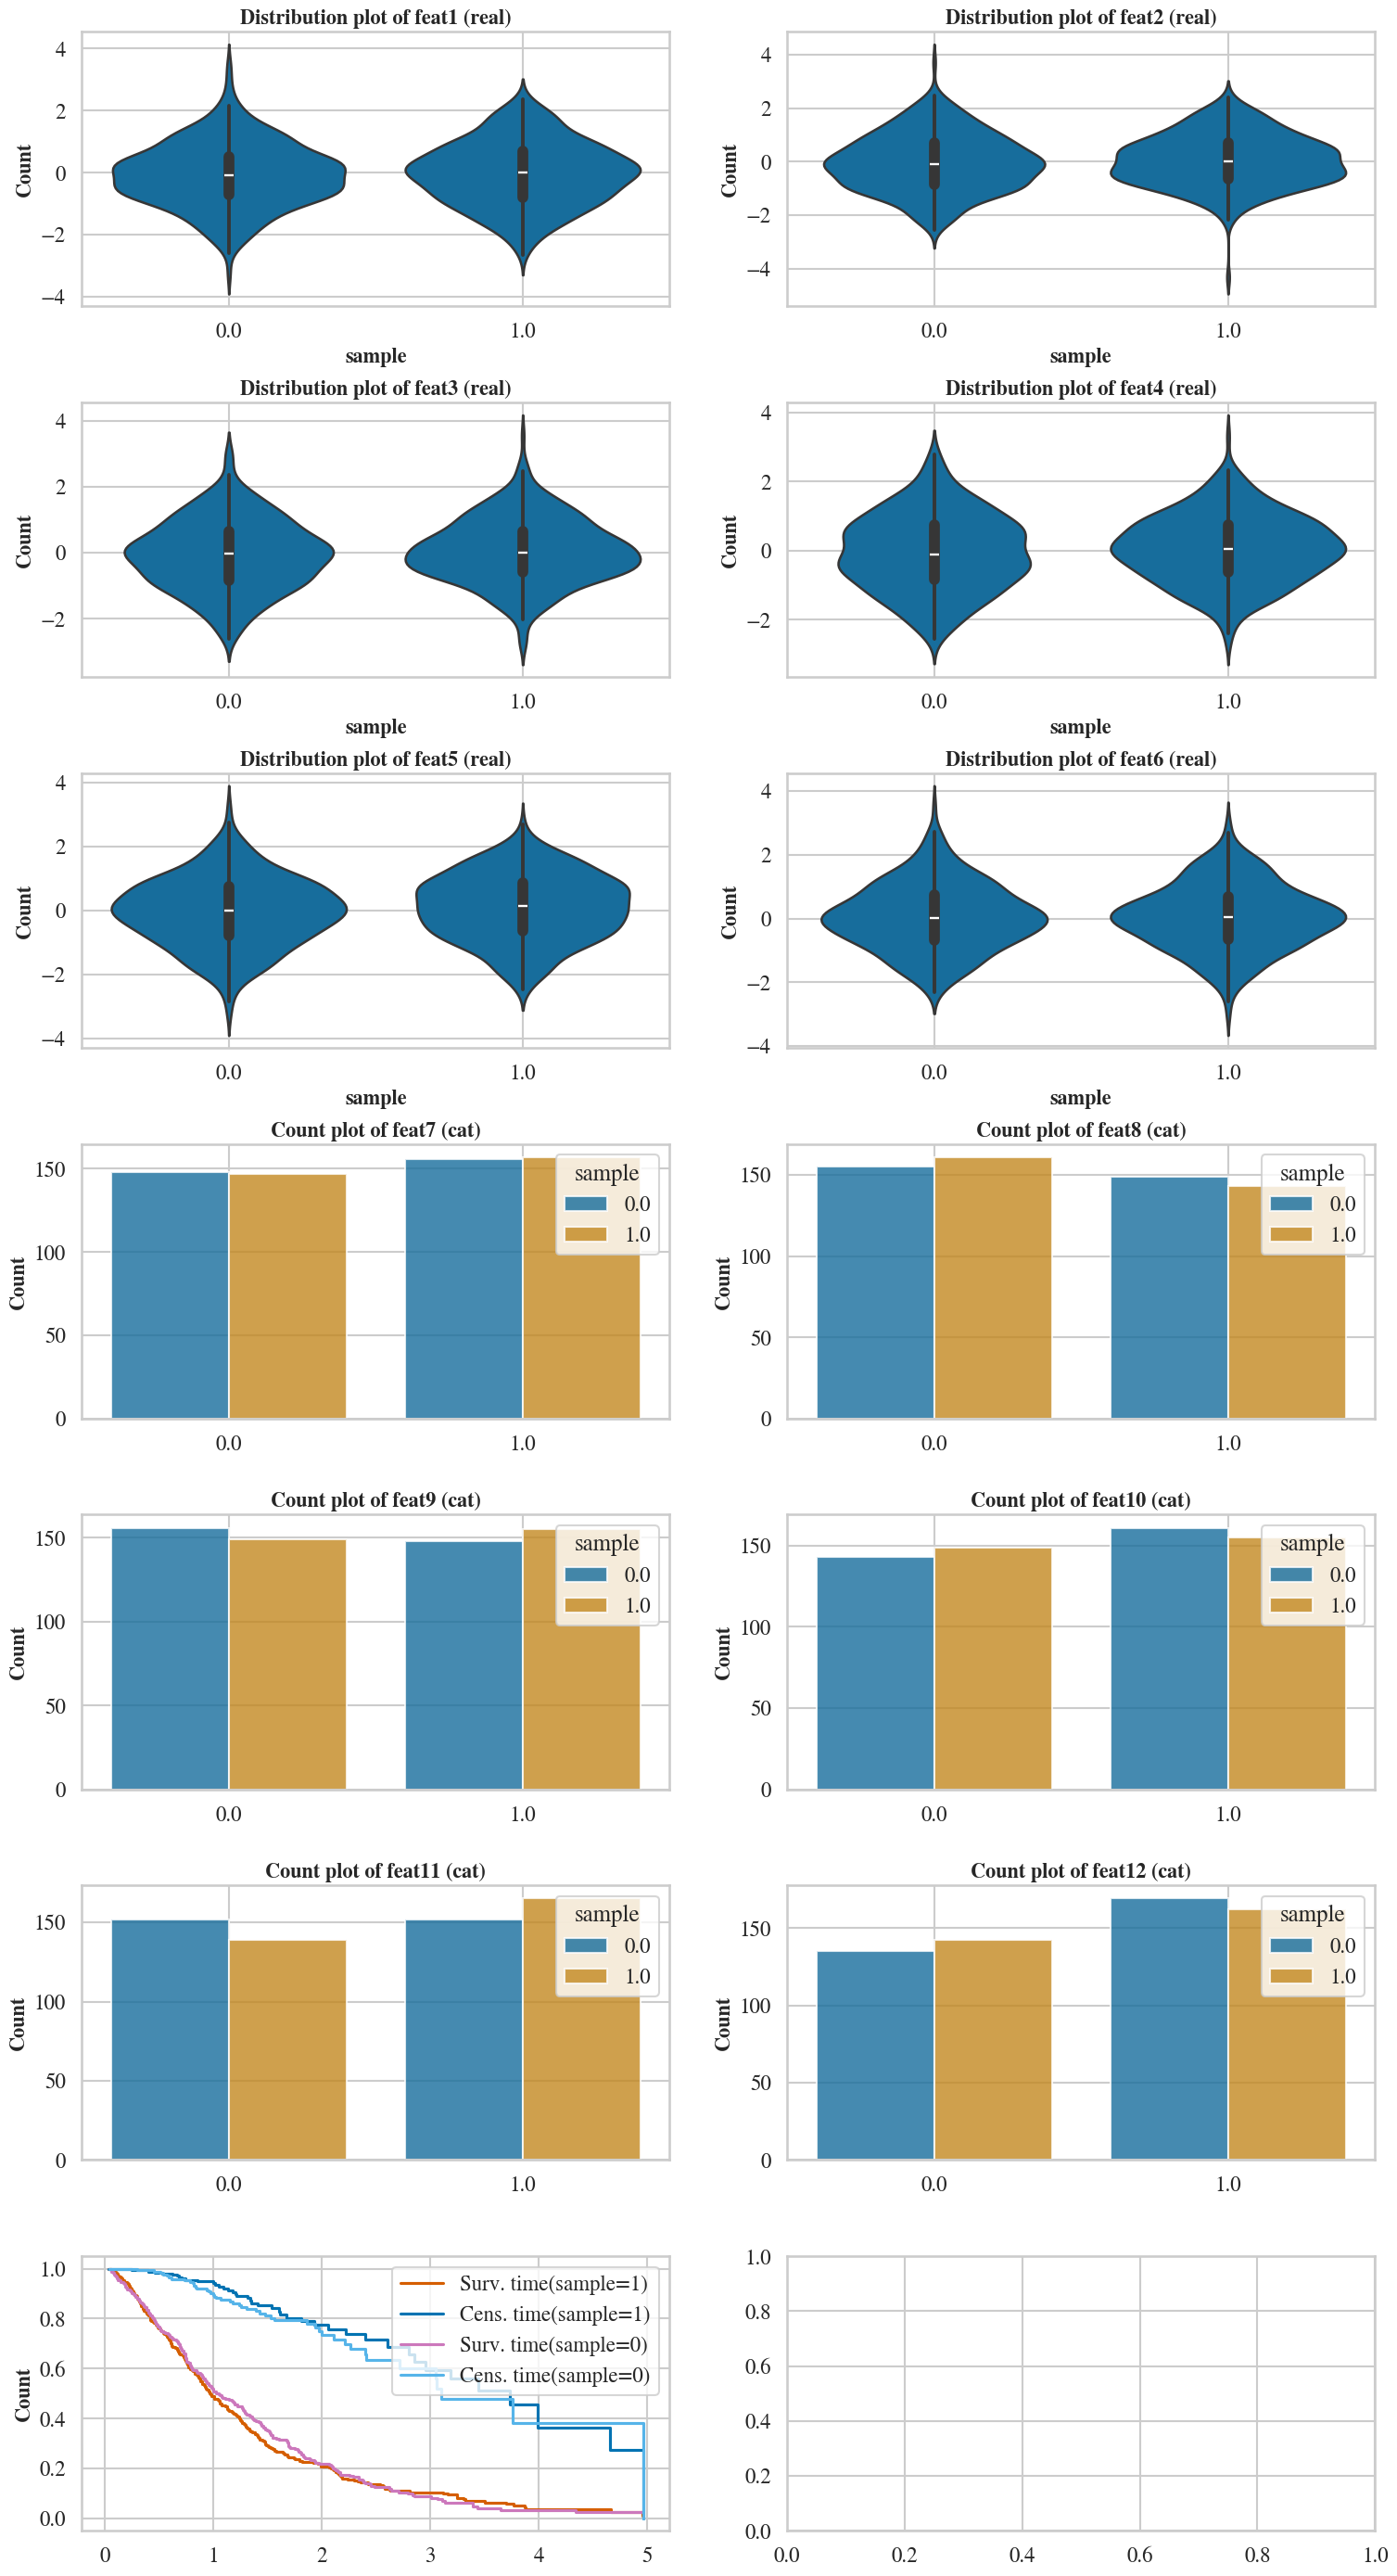

In [9]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)
df_init_control_ext['sample'] = 1

sel_idx = 2
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=control_fnames)
df_gen_control_ext_sel['sample'] = 0

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

## 4. Log-rank test

In [11]:
from metrics import log_rank, cox_estimation

data_syn = []
for i in range(n_generated_dataset):
    df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control['treatment'] = 0
    data_syn.append(pd.concat([df_init_treated, df_gen_control], ignore_index=True))

LR_init, LR_syn = log_rank(df_init, data_syn)
coef_init, coef_syn, cox_p_value_init, cox_p_value_syn = cox_estimation(df_init, data_syn)

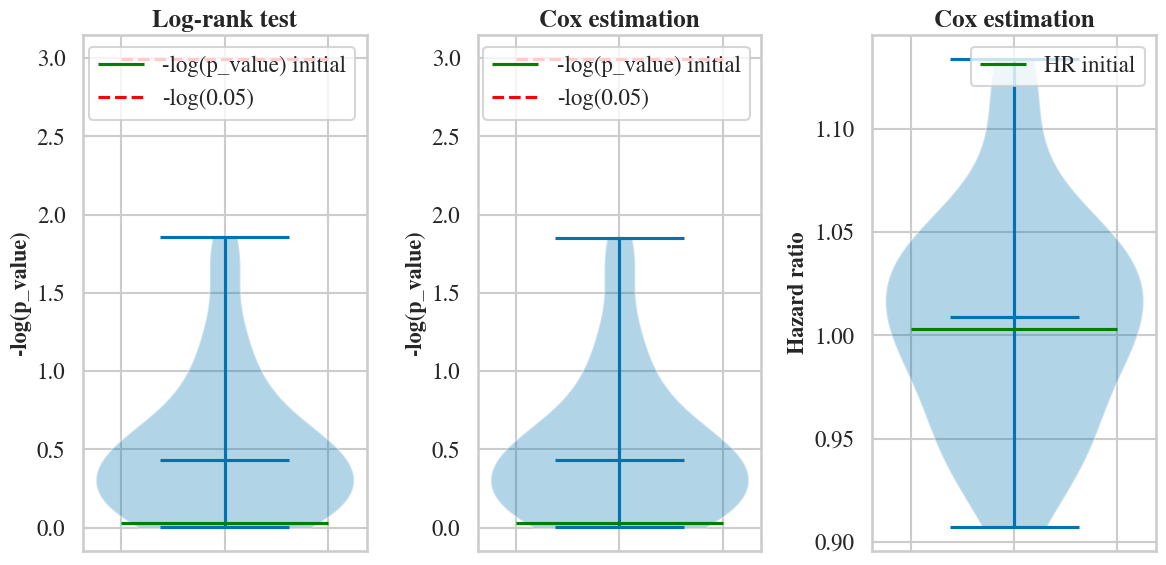

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

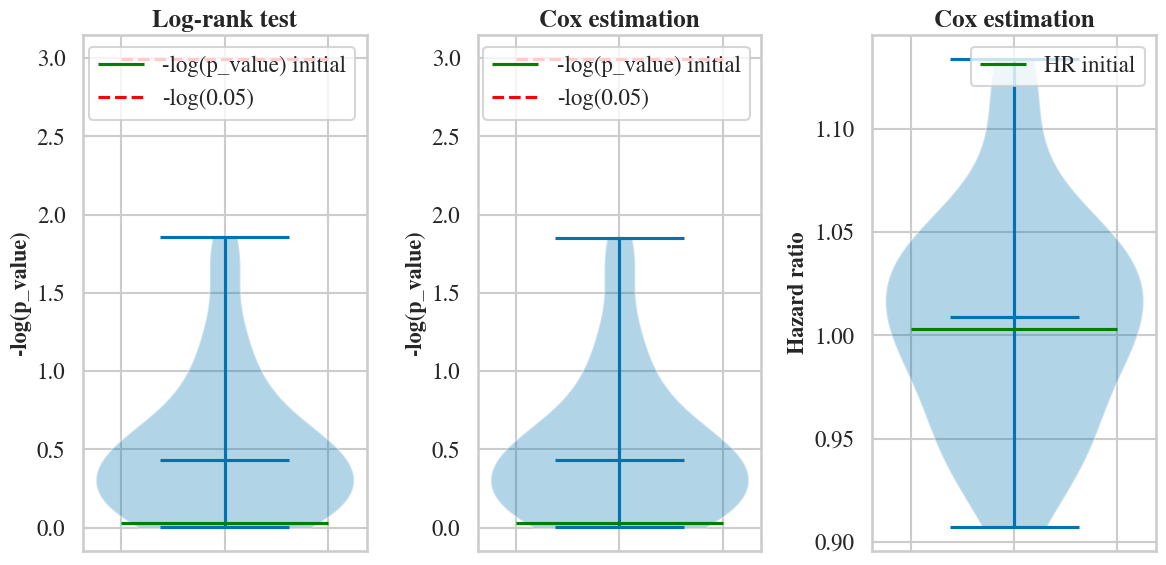

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()